# Analyse de sensibilité et loi conditionnelle dans un exemple non-linéaire

## Introduction

On considère la fonction $g$ définie par :
$$
g(X_1,X_2,X_3) = X_1 (X_2-X_1)+X_3
$$
pour tout $X_1,X_2,X_3\in\mathbb{R}$. 
Les trois variables d'entrée sont supposées indépendante et suivre les lois gaussiennes spécifiées dans le tableau suivant.

| Variable | Distribution |
|---|---|
| $X_1$ | Normale($\mu_1=0.1$,$\sigma_1 = 1$) |
| $X_2$ | Normale($\mu_2=1$,$\sigma_2 = 2$) |
| $X_3$ | Normale($\mu_3=2$,$\sigma_3 = 0.2$) |

## Analyse de sensibilité

L'analyse de sensibilité de ce modèle révèle que la variable $X_1$ est la plus importante, suivie de $X_2$. La variable $X_3$ ne compte presque pas et pourrait être remplacée par une constante. Pour garantir que $Y > 0$, la variable $X_1$ doit être contrôlée plus précisément : la remplacer par son espérance $E(X_1)$ permet de garantir que $Y>0$ avec une grande probabilité.  

L'objectif de cet exercice est de calculer puis dessiner les lois de 
* $Y$, 
* $Y|X_1=E(X_1)$, 
* $Y|X_2=E(X_2)$, 
* $Y|X_2=E(X_3)$.

Pour cela, nous utiliser une méthode d'estimation à noyau dans le but d'approcher la loi de chaque couple $(Y,X_1)$, $(Y,X_2)$ et $(Y,X_3)$. Puis nous utilisons la méthode `computeConditionalPDF` pour dessiner la densité de probabilité de chaque loi conditionnelle.

## Référence

"Analyse de sensibilité quantitative", Séance 8: analyse de sensibilité, G. Perrin, guillaume.perrin@polytechnique.org, Année 2017-2018

In [1]:
import openturns as ot
import openturns.viewer
import pylab as pl
import numpy as np

In [2]:
g = ot.SymbolicFunction(["X1","X2","X3"],["X1*(X2-X1)+X3"])
g

class=SymbolicFunction name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[X1,X2,X3,y0] evaluationImplementation=class=SymbolicEvaluation name=Unnamed inputVariablesNames=[X1,X2,X3] outputVariablesNames=[y0] formulas=[X1*(X2-X1)+X3] gradientImplementation=class=SymbolicGradient name=Unnamed evaluation=class=SymbolicEvaluation name=Unnamed inputVariablesNames=[X1,X2,X3] outputVariablesNames=[y0] formulas=[X1*(X2-X1)+X3] hessianImplementation=class=SymbolicHessian name=Unnamed evaluation=class=SymbolicEvaluation name=Unnamed inputVariablesNames=[X1,X2,X3] outputVariablesNames=[y0] formulas=[X1*(X2-X1)+X3]

In [3]:
X1 = ot.Normal(0.1,1)
X2 = ot.Normal(1,2)
X3 = ot.Normal(2,0.2)

In [4]:
X = ot.ComposedDistribution([X1,X2,X3])
XRV = ot.RandomVector(X)
Y = ot.RandomVector(g,XRV)

In [5]:
n = 100000
sampleX = X.getSample(n)
sampleY = g(sampleX)

Nous créons une première variable `fittedDistY` qui représente une approximation de la loi de $Y$.

In [6]:
kernel = ot.KernelSmoothing()
fittedDistY = kernel.build(sampleY)
fittedDistY.setDescription("Y")

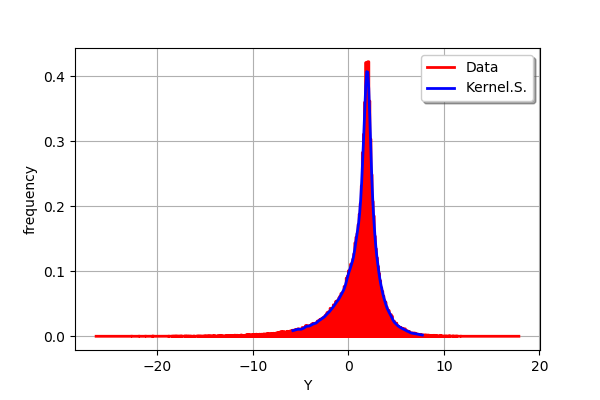

In [7]:
histo = ot.HistogramFactory().build(sampleY).drawPDF()
histo.setXTitle("Y")
histo.setTitle("")
histo.setLegends(["Data"])
graphYPDF = fittedDistY.drawPDF()
graphYPDF.setXTitle("Y")
graphYPDF.setColors(["blue"])
graphYPDF.setLegends(["Kernel.S."])
histo.add(graphYPDF)
histo

In [8]:
dimX = X.getDimension()

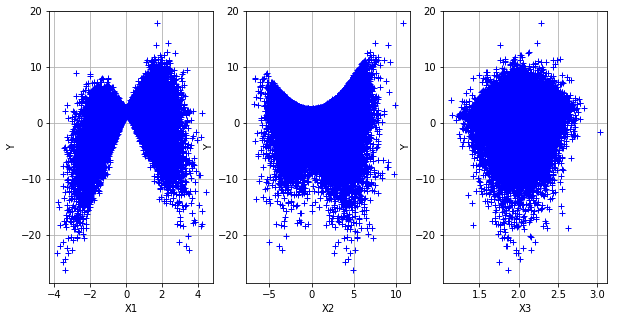

In [9]:
fig = pl.figure(figsize=(10,5))
for i in range(dimX):
    ax = fig.add_subplot(1, dimX, i+1)
    graph = ot.Graph('', 'X%d' % (i+1), 'Y', True, '')
    cloud = ot.Cloud(sampleX[:,i],sampleY)
    graph.add(cloud)
    _ = ot.viewer.View(graph, figure=fig, axes=[ax])

L'analyse du graphique montre que la variable $X_3$ n'a pas d'influence en moyenne. Toutefois, il est difficile de se prononcer sur la hiérarchisation entre $X_1$ et $X_2$ uniquement sur la base de ce graphique.

In [10]:
data = ot.Sample(n,dimX+1)
data[:,0:dimX] = sampleX
data[:,dimX] = sampleY[:,0]

La fonction suivante retourne un graphique associé aux échantillons `sampleX` et `sampleY` et dessine la loi inconditionnelle de $Y$ et la loi conditionnelle de $Y|X_i=E(X_i)$. Pour cela, on génère un échantillon de dimension 2 dont la première composante est la i-ème colonne de `sampleX` et la seconde est égale à `sampleY`. Puis on utilise la méthode `computeConditionalPDF` pour calculer la densité de probabilité conditionnelle. 

In [11]:
def drawConditionnalDistribution(sampleX,sampleY,i):
    dataX1Y = ot.Sample(n,2)
    dataX1Y[:,0] = sampleX[:,i]
    dataX1Y[:,1] = sampleY[:,0]
    kernel = ot.KernelSmoothing()
    fittedDistX1Y = kernel.build(dataX1Y)
    mu1 = sampleX.computeMean()[i]
    npoints = 100
    ymin = sampleY.computeQuantile(0.05)[0]
    ymax = sampleY.computeQuantile(0.95)[0]
    y = ot.Sample(np.linspace(ymin,ymax,npoints),1)
    yPDF = ot.Sample(npoints,1)
    for j in range(npoints):
        yPDF[j,0] = fittedDistX1Y.computeConditionalPDF(y[j,0],ot.Point([mu1]))
    graph = ot.Graph('Y|X%d=E(X%d)' % (i+1,i+1), 'Y', 'PDF', True, '')
    curve = ot.Curve(y,yPDF)
    curve.setLegend('Y|X%d=E(X%d)' % (i+1,i+1))
    graph.add(curve)
    graphYPDF = fittedDistY.drawPDF()
    graphYPDF.setLegends("Y")
    graph.add(graphYPDF)
    graph.setLegendPosition('topright')
    return graph

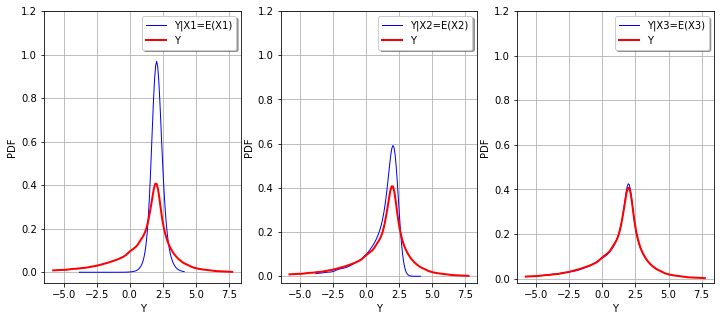

In [12]:
fig = pl.figure(figsize=(12,5))
for i in range(dimX):
    ax = fig.add_subplot(1, dimX, i+1)
    graph = drawConditionnalDistribution(sampleX,sampleY,i)
    # Set the same vertical maximum PDF for all graphics
    bb = graph.getBoundingBox()
    ub = bb.getUpperBound()
    ub[1] = 1.2
    bb.setUpperBound(ub)
    graph.setBoundingBox(bb)
    graph.setTitle("")
    _ = ot.viewer.View(graph, figure=fig, axes=[ax])

On observe que, pour $X_3$, les lois conditionnelles et inconditionnelles sont très proches. Par conséquent, la variable $X_3$ pourrait être fixée à sa valeur moyenne, sans que cela ne change la variance de $Y$. Les deux variables $X_1$ et $X_2$ ont une influence sur la variabilité de $Y$. Il semble que la variable $X_1$ a plus d'influence que $X_2$, mais cela mériterait une analyse plus approfondie pour quantifier cette influence.